<a href="https://colab.research.google.com/github/algo21-221040114/PytorchTest/blob/main/Model_Transformer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sweetviz

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import sweetviz as sv
from pandas_profiling import ProfileReport

In [2]:
import pandas as pd
import numpy as np

import math
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/sample_data/000001.SS.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-16,3107.669922,3177.790039,3023.300049,3170.709961,3170.709961,444700
2022-03-17,3215.010010,3260.169922,3202.929932,3215.040039,3215.040039,420800
2022-03-18,3207.149902,3260.780029,3197.360107,3251.070068,3251.070068,373000
2022-03-21,3255.620117,3267.500000,3223.389893,3253.689941,3253.689941,354200
2022-03-22,3249.540039,3279.110107,3239.530029,3259.860107,3259.860107,361200


In [ ]:
# Plot
fig, ax = plt.subplots()
ax.plot(df.index, df['High'], color='y', label='high')
ax.plot(df.index, df['Close'], color='b', label='close')
ax.set_title('000001.SS')
ax.legend()
plt.show()

In [ ]:
# EDA 
def eda_sweetviz(df, report_name, target=None):
    # target certain data
    sweet_report = sv.analyze(df, target_feat=target)
    # in notebook, download the file and open in the browser
    sweet_report.show_html(f'{report_name}.html')

def eda_sweetviz_compare(df1, df2, report_name, feature, target):
    # compare two datasets
    feature_config = sv.FeatureConfig(force_text=feature, force_cat=feature)
    sweet_report = sv.compare(df1, df2, feat_cfg=feature_config, target_feat=target)
    sweet_report.show_html(f'{report_name}_compare.html')


eda_sweetviz(df, 'Daily Data of 000001.SS')

def eda_pandas_profilling(df, report_name):
    # directly show in notebook
    profile = ProfileReport(df, title=report_name, explorative=True)
    return profile

eda_pandas_profilling(df, '000001.SS Report')

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [51]:
# Data Preprocess
cl = df['Close']
features = np.array((df['Open'], df['High'], df['Low'], df['Close'])).T
length = features.shape[0] # total time length
src = []
tgt = []
tgt_y = []

for i in range(length-12):
  s = features[i: i+10, :]
  src.append(s)

  t = features[i+11, :]
  tgt.append(t)

  t_y = features[i+12, -1] # close price
  tgt_y.append(t_y)

train_src = src[:220]
test_src = src[220:]

train_tgt = tgt[:220]
test_tgt = tgt[220:]

train_tgt_y = tgt_y[:220]
test_tgt_y = tgt_y[220:]

print(len(train_tgt_y))

220


In [5]:
def shuffle_data(feature, target, target_y):
    """
    :param feature: encoder输入特征, list
    :param target: decoder输入特征
    :param target_y: ground truth
    :param shuffle: 是否打乱顺序
    :return:
    """
    # 输入all_datas的每一项必须是numpy数组
    feature = [np.array(x) for x in feature]
    target = [np.array(x) for x in target]
    target_y = [np.array(x) for x in target_y]

    # 获取样本大小
    data_size = len(feature)

    # 随机生成打乱的索引
    p = np.random.permutation(data_size)
    # 重新组织数据
    feature = torch.Tensor(np.array(feature)[p])
    target =  torch.Tensor(np.array(target)[p]).unsqueeze(1)
    target_y =  torch.Tensor(np.array(target_y)[p])

    return feature, target, target_y

In [6]:
# 策略：使用前十个交易日的close信息预测当日close
class QuantModel(nn.Module):

  def __init__(self):
      super(QuantModel, self).__init__()

      self.transformer = nn.Transformer(d_model = 4,
                                        nhead=2,
                                        num_encoder_layers=12,
                                        num_decoder_layers=12,
                                        dim_feedforward=128,
                                        dropout=0.2,
                                        activation='relu',
                                        custom_encoder=None,
                                        custom_decoder=None,
                                        batch_first = True)
      self.out_linear = nn.Linear(4, 1)

  def forward(self, src, tgt):

      tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size()[1])
      
      out = self.transformer(src, tgt, tgt_mask=tgt_mask)

      return out

model = QuantModel()

In [65]:
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

In [66]:
# Train model
data_size = 220
batch_size = 16
total_loss = 0
epochs = 100
batch_count = data_size//batch_size

for epoch in range(1, epochs + 1):

    total_loss = 0
    optimizer.zero_grad()
    src, tgt, tgt_y = shuffle_data(train_src, train_tgt, train_tgt_y)

    for batch in range(batch_count+1):
      start = batch*batch_size
      if start >= data_size:
        break
      else:
        end = min((batch+1)*batch_size, data_size)
          
        src1 = src[start:end]
        tgt1 = tgt[start:end]
        tgt_y1 = tgt_y[start:end]
        out = model(src1, tgt1)
        out = model.out_linear(out)
        loss = criteria(out.contiguous().view(-1, out.size(-1)), 
                        tgt_y1.contiguous().view(-1, tgt_y1.size(-1)))

        loss.backward()
        optimizer.step()
        total_loss += loss

    # 每10次打印一下loss
    if epoch != 0 and epoch % 5 == 0:
        print("Epoch {}, total_loss: {}".format(epoch, total_loss))
        total_loss = 0

Epoch 5, total_loss: 183129.46875
Epoch 10, total_loss: 182032.609375
Epoch 15, total_loss: 185362.34375
Epoch 20, total_loss: 175949.140625
Epoch 25, total_loss: 167627.203125
Epoch 30, total_loss: 184319.296875
Epoch 35, total_loss: 187667.421875
Epoch 40, total_loss: 177938.140625
Epoch 45, total_loss: 183218.84375
Epoch 50, total_loss: 169554.859375
Epoch 55, total_loss: 182531.53125
Epoch 60, total_loss: 194891.984375
Epoch 65, total_loss: 181215.71875
Epoch 70, total_loss: 185020.421875
Epoch 75, total_loss: 181714.203125
Epoch 80, total_loss: 177648.328125
Epoch 85, total_loss: 168807.015625
Epoch 90, total_loss: 168958.53125
Epoch 95, total_loss: 180533.75
Epoch 100, total_loss: 178314.375


In [52]:
# Test model
test_src = torch.Tensor(test_src)
test_tgt = torch.Tensor(test_tgt).unsqueeze(1)
print(test_src.size())
print(test_tgt.size())

torch.Size([12, 10, 4])
torch.Size([12, 1, 4])


[array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32), array([3143.5735], dtype=float32)]


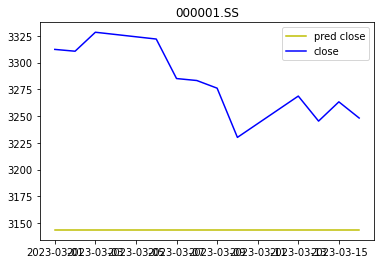

In [67]:
model = model.eval()
output = model(test_src, test_tgt)
output = model.out_linear(output) #(batch_size, pred_len, prediction)
output = list(output.squeeze(-1).detach().numpy())
print(output)

fig, ax = plt.subplots()
ax.plot(df.index[-len(output):], output, color='y', label='pred close')
ax.plot(df.index[-len(output):], df['Close'][-len(output):], color='b', label='close')
ax.set_title('000001.SS')
ax.legend()
plt.show()